In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
#from c.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification

In [2]:
orig_data = pd.read_excel("OppScrData.xlsx")
#print(orig_data)
for col in orig_data.columns:
    new_col = '_'.join(col.split())
    orig_data.rename(columns={col:new_col}, inplace=True)
#print(orig_data)

In [3]:
data = orig_data.copy()
data = data.loc[:, ['Record_ID', 'Visit_ID', 'PT_ID','DEATH_[d_from_CT]','L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']]
#print(data.shape)

col = 'Liver_HU_(Median)'
data.loc[:, col] = pd.to_numeric(data[col], errors='coerce')
data.loc[:, col] = data[col].astype(float)
#print(data)

col = 'DEATH_[d_from_CT]'
#print(data.head(10))
#print(orig_data)
data.loc[~data[col].isna(), col] = 1
data.loc[data[col].isna(), col] = 0
#print(data.shape)
#print(data[col])
#print(data.head(10))
#print(data.loc[data[col] == 0, :].shape)
data.rename(columns={col:'death'}, inplace=True)
col = 'death'
#print(data.head(10))
print(data.loc[data[col] == 0, :].shape)
msk = np.random.rand(data.shape[0]) < 0.8
#print(msk)
train = data[msk]
test = data[~msk]
#print(train)
#print(test)
feats = ['L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']
label = col

(8674, 15)


## EDA

In [4]:
orig_data[~orig_data['DEATH_[d_from_CT]'].isna()].shape

(549, 115)

<AxesSubplot:ylabel='Frequency'>

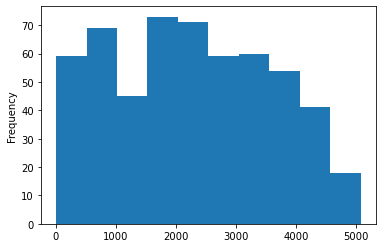

In [5]:
orig_data[orig_data['DEATH_[d_from_CT]']<5071]['DEATH_[d_from_CT]'].plot.hist()

In [6]:
"""
train.groupby('DEATH_[d_from_CT]')['L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)'].describe().T[48:]
"""

"\ntrain.groupby('DEATH_[d_from_CT]')['L1_HU_BMD',\n       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)',\n       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',\n       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)'].describe().T[48:]\n"

Record_ID


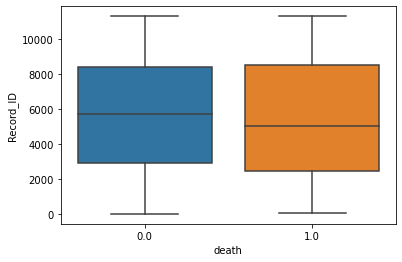

Visit_ID


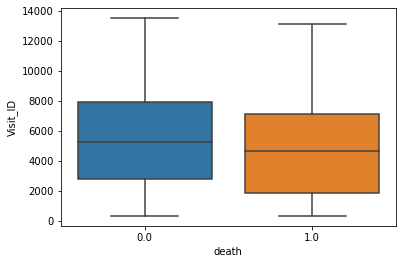

PT_ID


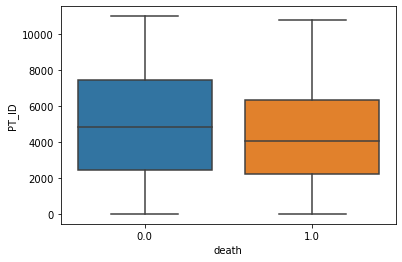

death


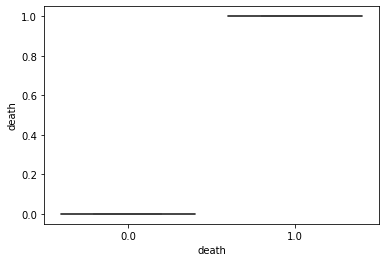

L1_HU_BMD


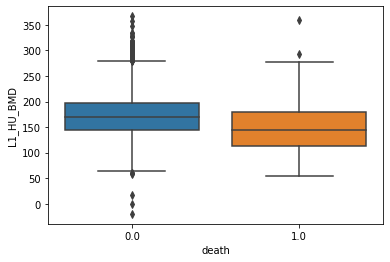

TAT_Area_(cm2)


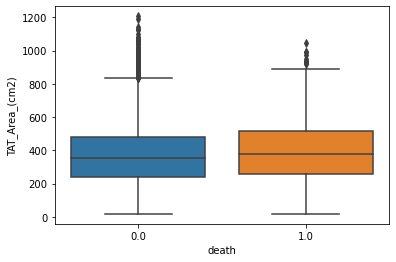

Total_Body_Area_EA_(cm2)


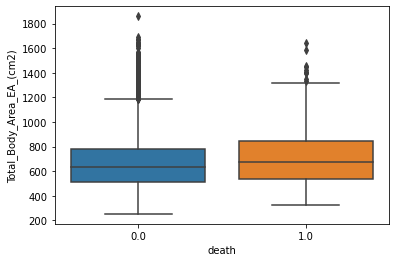

VAT_Area_(cm2)


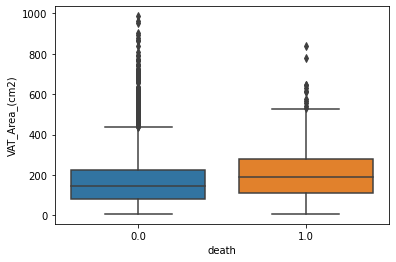

SAT_Area_(cm2)


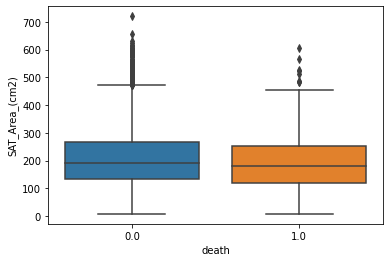

VAT/SAT_Ratio


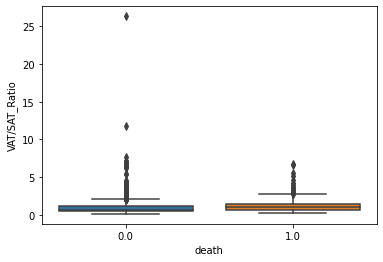

Muscle_HU


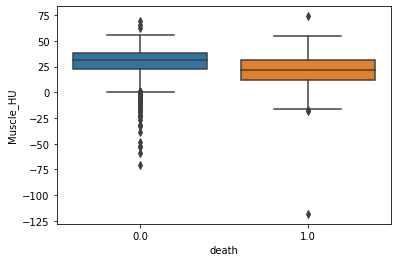

Muscle_Area_(cm2)


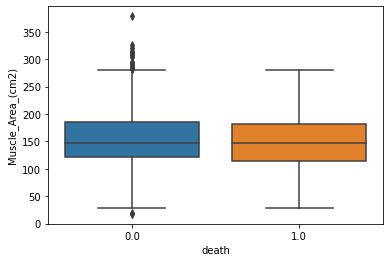

L3_SMI_(cm2/m2)


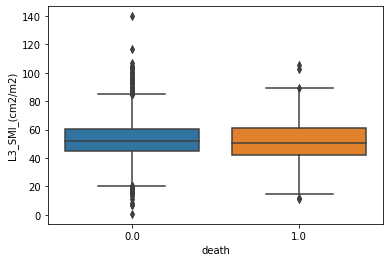

AoCa_Agatston


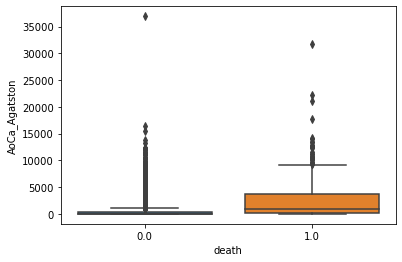

Liver_HU_(Median)


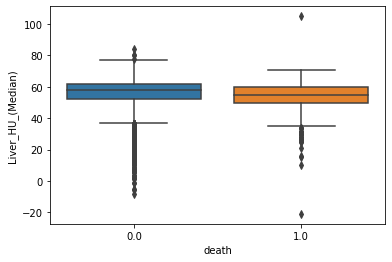

In [7]:
import seaborn as sns
for col in train.columns:
    print(col)
    sns.boxplot(x='death', y=col, data=train)
    plt.show()

## SMOTE

In [8]:
X_train = train[feats]
y_train = train[label]
print(X_train.shape)
#print(X_train.head(10))
print(y_train.shape)
#print(y_train.head(10))
print(Counter(y_train))
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)
print(X_train.shape)
print(y_train.shape)
#print(X_train[X_train.isna().any(axis=1)])
#print(X_train.loc[X_train[col:col in X_train.columns()].isna(), :])
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)
# summarize the new class distribution
print(Counter(y_train))
#print(X_train.head(10))
#print(y_train.head(10))

(7427, 11)
(7427,)
Counter({0.0: 6992, 1.0: 435})
(7427, 11)
(7427,)
Counter({0.0: 1398, 1.0: 699})


## Regression

In [20]:
#model = LogisticRegression(random_state=0).fit(X_train, y_train)
model = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
# evaluate pipeline
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
#print('Mean ROC AUC: %.3f' % np.mean(scores))

In [21]:
X_test = test[feats]
Y_test = test[label]
X_test = X_test.fillna(0)
Y_test = Y_test.fillna(0)
print(Counter(Y_test))
preds = model.predict(X_test)
accuracy_score(Y_test, preds)

Counter({0.0: 1682, 1.0: 114})


0.755011135857461

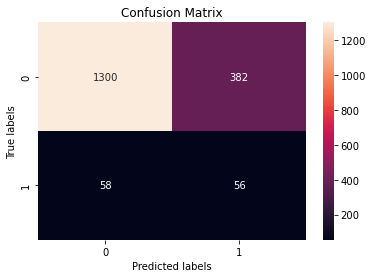

In [23]:
ax= plt.subplot()
cm = confusion_matrix(Y_test, preds)
labels = [0,1]
sns.heatmap(cm, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);